Week 2 Assignment - Jivesh K 
Wildfire Prediction Using CNN (Binary Classification)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageFile
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [6]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [7]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
base_dir = '/Users/jiveshkarthik/Documents/Visual Studio Code/NIT Internship/Week2/wildfire prediction'  

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = test_val_datagen.flow_from_directory(
    os.path.join(base_dir, 'valid'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_val_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False 
)

print("Class indices:", train_generator.class_indices)

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Class indices: {'nowildfire': 0, 'wildfire': 1}


Image preprocessing

In [8]:
def preprocess_image(img_path, target_size=(128, 128)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0 
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, img

Displaying sample test images

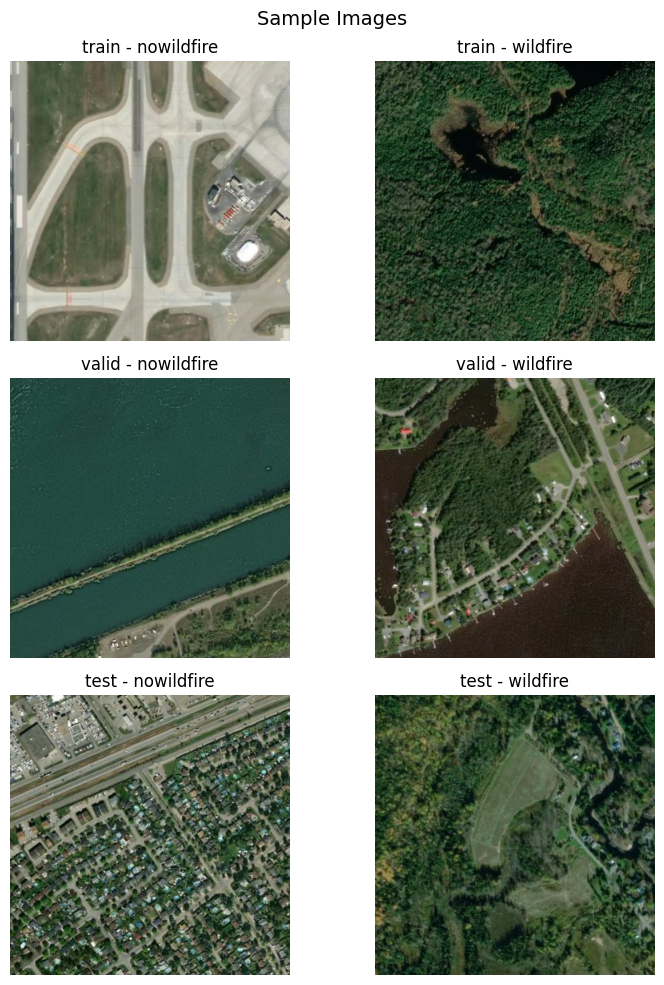

In [9]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def show_sample_images():
    sets = ['train', 'valid', 'test']
    categories = ['nowildfire', 'wildfire']

    plt.figure(figsize=(8, 10))  

    for row, dataset in enumerate(sets):
        for col, category in enumerate(categories):
            folder = os.path.join(base_dir, dataset, category)
            image_file = os.listdir(folder)[0] 
            img_path = os.path.join(folder, image_file)
            img = Image.open(img_path)

            plt.subplot(3, 2, row * 2 + col + 1)
            plt.imshow(img)
            plt.title(f'{dataset} - {category}')
            plt.axis('off')

    plt.suptitle("Sample Images", fontsize=14)
    plt.tight_layout()
    plt.show()

show_sample_images()


Model building (CNN using Keras)

In [10]:

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') 
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/Users/jiveshkarthik/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,449 (28.20 MB)

 Trainable params: 7,392,449 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10


/Users/jiveshkarthik/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


946/946 ━━━━━━━━━━━━━━━━━━━━ 91s 96ms/step - accuracy: 0.8853 - loss: 0.2838 - val_accuracy: 0.9348 - val_loss: 0.1655
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 95s 100ms/step - accuracy: 0.9313 - loss: 0.1814 - val_accuracy: 0.9467 - val_loss: 0.1505
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 96s 101ms/step - accuracy: 0.9410 - loss: 0.1590 - val_accuracy: 0.9408 - val_loss: 0.1620
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 170s 179ms/step - accuracy: 0.9455 - loss: 0.1469 - val_accuracy: 0.9429 - val_loss: 0.1537
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 134s 142ms/step - accuracy: 0.9479 - loss: 0.1426 - val_accuracy: 0.9563 - val_loss: 0.1274
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 93s 98ms/step - accuracy: 0.9537 - loss: 0.1317 - val_accuracy: 0.9598 - val_loss: 0.1145
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 103s 109ms/step - accuracy: 0.9506 - loss: 0.1358 - val_accuracy: 0.9546 - val_loss: 0.1198
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 102s 108ms/step - accuracy: 0.9548 - loss: 0.1243 - v

Evaluation (Accuracy, loss plots, Confusion Matrix)


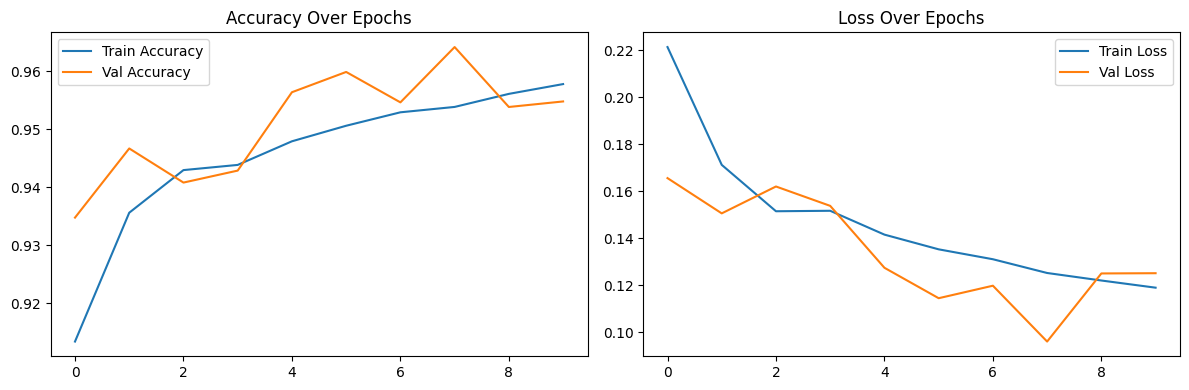

In [16]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step


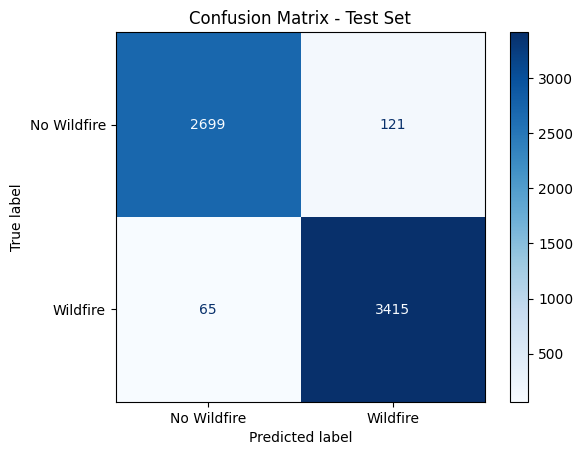

              precision    recall  f1-score   support

 No Wildfire       0.98      0.96      0.97      2820
    Wildfire       0.97      0.98      0.97      3480

    accuracy                           0.97      6300
   macro avg       0.97      0.97      0.97      6300
weighted avg       0.97      0.97      0.97      6300



In [17]:
preds = model.predict(test_generator)
y_pred = (preds > 0.5).astype(int)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Wildfire', 'Wildfire'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()

print(classification_report(y_true, y_pred, target_names=['No Wildfire', 'Wildfire']))

predicting no wildfire / wildfire using sample images as input

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
No wildfire.


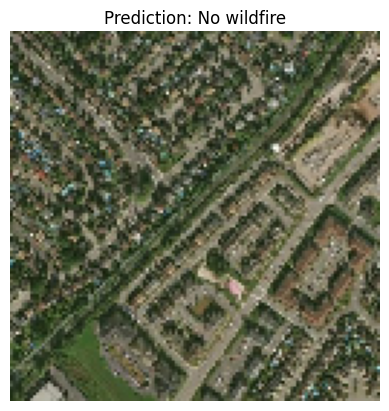

In [28]:
def preprocess_image(img_path, target_size=(128, 128)):
    img = load_img(img_path, target_size=target_size)
    original_img = np.array(img)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, original_img

test_img_path = '/Users/jiveshkarthik/Documents/Visual Studio Code/NIT Internship/Week2/wildfire prediction/test/nowildfire/-73.43705,45.463087.jpg'

processed_img, original_img = preprocess_image(test_img_path)
prediction = model.predict(processed_img)

if prediction[0][0] > 0.5:
    print("Wildfire detected!")
else:
    print("No wildfire.")
    
plt.imshow(original_img)
plt.axis('off')
plt.title("Prediction: " + ("Wildfire" if prediction[0][0] > 0.5 else "No wildfire"))
plt.show()
